# Data Augmentation for Dataset Balancing

Ce notebook permet d'augmenter votre dataset en appliquant 6 types d'augmentations pour équilibrer les classes.

## 1. Imports

In [1]:
import os
from PIL import Image, ImageOps
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## 2. Fonctions d'Augmentation

Définition des 6 types d'augmentation géométrique.

In [2]:
def flip_image(image):
    """
    Retournement horizontal de l'image.

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image retournée horizontalement
    """
    return ImageOps.mirror(image)


def rotate_image(image):
    """
    Rotation aléatoire (90, 180 ou 270 degrés).

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image tournée
    """
    return image.rotate(random.choice([90, 180, 270]))


def skew_image(image):
    """
    Inclinaison (skew) horizontale de l'image.

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image inclinée
    """
    width, height = image.size
    xshift = width * random.uniform(-0.1, 0.1)
    new_width = width + abs(xshift)
    image = image.transform((int(new_width), height),
                            Image.AFFINE,
                            (1, xshift / width, 0, 0, 1, 0),
                            Image.BICUBIC)
    return image


def shear_image(image):
    """
    Cisaillement (shear) de l'image.

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image cisaillée
    """
    width, height = image.size
    m = random.uniform(-0.2, 0.2)
    xshift = abs(m) * width
    new_width = width + int(round(xshift))
    image = image.transform((new_width, height),
                            Image.AFFINE,
                            (1, m, -xshift if m > 0 else 0, 0, 1, 0),
                            Image.BICUBIC)
    return image


def crop_image(image):
    """
    Recadrage aléatoire de l'image.

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image recadrée
    """
    width, height = image.size
    left = random.randint(0, width // 8)
    top = random.randint(0, height // 8)
    right = random.randint(7 * width // 8, width)
    bottom = random.randint(7 * height // 8, height)
    return image.crop((left, top, right, bottom))


def distort_image(image):
    """
    Distorsion perspective de l'image.

    Args:
        image (PIL.Image): Image d'entrée

    Returns:
        PIL.Image: Image avec distorsion perspective
    """
    width, height = image.size
    coeffs = find_coeffs(
        [(random.uniform(0, width * 0.1),
          random.uniform(0, height * 0.1)),
         (width - random.uniform(0, width * 0.1),
          random.uniform(0, height * 0.1)),
         (width - random.uniform(0, width * 0.1),
          height - random.uniform(0, height * 0.1)),
         (random.uniform(0, width * 0.1),
          height - random.uniform(0, height * 0.1))],
        [(0, 0), (width, 0), (width, height), (0, height)]
    )
    return image.transform((width, height),
                           Image.PERSPECTIVE,
                           coeffs,
                           Image.BICUBIC)


def find_coeffs(pa, pb):
    """
    Calcule les coefficients pour la transformation perspective.

    Args:
        pa (list): Points de départ
        pb (list): Points d'arrivée

    Returns:
        np.ndarray: Coefficients de transformation
    """
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0,
                       -p2[0] * p1[0], -p2[0] * p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1,
                       -p2[1] * p1[0], -p2[1] * p1[1]])

    A = np.matrix(matrix, dtype=float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

print("Fonctions d'augmentation définies")

Fonctions d'augmentation définies


## 3. Visualisation des Augmentations

Visualisons l'effet de chaque augmentation sur une image d'exemple.

In [3]:
# Chemin vers une image d'exemple
EXAMPLE_IMAGE = "../Grape/Grape_spot/image (8).JPG"

if not os.path.exists(EXAMPLE_IMAGE):
    print(f"Image non trouvée: {EXAMPLE_IMAGE}")
else:
    print(f"Image trouvée: {EXAMPLE_IMAGE}")

Image trouvée: ../Grape/Grape_spot/image (8).JPG


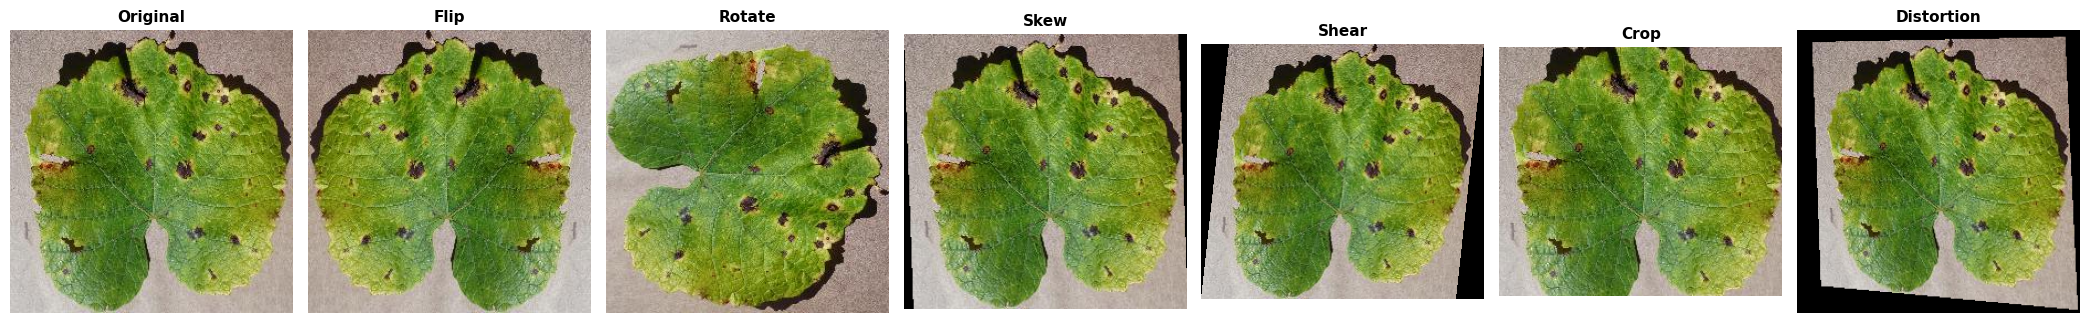

In [4]:
def display_augmentations(image_path):
    """
    Affiche l'image originale et les 6 augmentations côte à côte.

    Args:
        image_path (str): Chemin vers l'image à augmenter
    """
    image = Image.open(image_path)

    augmentations = [
        ('Original', image),
        ('Flip', flip_image(image)),
        ('Rotate', rotate_image(image)),
        ('Skew', skew_image(image)),
        ('Shear', shear_image(image)),
        ('Crop', crop_image(image)),
        ('Distortion', distort_image(image)),
    ]

    fig, axes = plt.subplots(1, 7, figsize=(21, 4))

    for ax, (name, aug_img) in zip(axes, augmentations):
        ax.imshow(aug_img)
        ax.set_title(name, fontsize=11, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

if os.path.exists(EXAMPLE_IMAGE):
    display_augmentations(EXAMPLE_IMAGE)

## 4. Analyse du Dataset Actuel

In [5]:
def analyze_dataset(directory):
    """
    Analyse le dataset et retourne les statistiques par classe.

    Args:
        directory (str): Chemin vers le dossier contenant les
        sous-dossiers de classes

    Returns:
        dict: Dictionnaire {plant_type: {disease: count}} avec le nombre
        d'images par maladie
    """
    plant_types = {}
    for subdir in os.listdir(directory):
        path = os.path.join(directory, subdir)
        if os.path.isdir(path):
            try:
                plant_type, disease = subdir.split('_', 1)
                if plant_type not in plant_types:
                    plant_types[plant_type] = {}
                num_images = len([f for f in os.listdir(path)
                                 if f.lower().endswith(('.jpg'))])
                plant_types[plant_type][disease] = num_images
            except ValueError:
                print(f"Dossier ignoré: {subdir} (format incorrect)")
    return plant_types

DATA_DIR = "../Apple"

if os.path.exists(DATA_DIR):
    print("=== ANALYSE DU DATASET ACTUEL ===")
    categories = analyze_dataset(DATA_DIR)

    for plant_type, diseases in categories.items():
        print(f"\n{plant_type}:")
        for disease, count in diseases.items():
            print(f"  {disease}: {count} images")
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE DU DATASET ACTUEL ===

Apple:
  Black_rot: 620 images
  rust: 275 images
  scab: 629 images
  healthy: 1640 images


## 5. Équilibrage du Dataset

Cette fonction augmente automatiquement les classes minoritaires pour atteindre le nombre d'images de la classe majoritaire.

In [6]:
def augment_image(image_path, output_dir, num_augmentations_needed=1):
    """
    Applique des augmentations aléatoires à une image et sauvegarde
    les résultats.

    Args:
        image_path (str): Chemin vers l'image source
        output_dir (str): Dossier de destination pour les images augmentées
        num_augmentations_needed (int): Nombre d'augmentations à créer

    Returns:
        int: Nombre d'augmentations créées avec succès
    """
    image = Image.open(image_path)
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    augmentations = [
        ('Flip', flip_image),
        ('Rotate', rotate_image),
        ('Skew', skew_image),
        ('Shear', shear_image),
        ('Crop', crop_image),
        ('Distortion', distort_image),
    ]

    selected_augmentations = random.sample(
        augmentations,
        min(num_augmentations_needed, len(augmentations))
    )

    augmented_count = 0
    for aug_name, aug_func in selected_augmentations:
        if augmented_count >= num_augmentations_needed:
            break
        try:
            augmented_image = aug_func(image)
            augmented_image_path = os.path.join(
                output_dir,
                f"{base_name}_{aug_name}_{random.randint(1000, 9999)}.JPG"
            )
            augmented_image.save(augmented_image_path)
            augmented_count += 1
        except Exception as e:
            print(f"  Erreur avec {aug_name}: {e}")

    return augmented_count


def balance_dataset(directory, dry_run=False):
    """
    Équilibre le dataset en augmentant les classes minoritaires
    jusqu'à atteindre le nombre d'images de la classe majoritaire.

    Args:
        directory (str): Chemin du dataset
        dry_run (bool): Si True, simule l'opération sans créer de fichiers

    Note:
        - Les images sont générées uniquement à partir des images originales
        - Chaque image peut recevoir jusqu'à 3 augmentations aléatoires
        - La barre de progression affiche l'avancement en temps réel
    """
    print("=== ANALYSE INITIALE ===")
    categories = analyze_dataset(directory)

    if not categories:
        print("Aucune catégorie trouvée!")
        return

    for plant_type, diseases in categories.items():
        print(f"\n=== ÉQUILIBRAGE DE {plant_type.upper()} ===")

        max_images = max(diseases.values())
        target_images = max_images

        print(f"Cible d'équilibrage: {target_images} images par classe")

        for disease, count in diseases.items():
            path = os.path.join(directory, f"{plant_type}_{disease}")
            print(f"\n{plant_type}_{disease}: {count} images")

            if count < target_images:
                needed = target_images - count
                print(f"  Besoin de {needed} images supplémentaires")

                if dry_run:
                    print(f"  [DRY RUN] Générerait {needed} nouvelles images")
                    continue

                # Récupérer les images originales
                original_images = [
                    os.path.join(path, file)
                    for file in os.listdir(path)
                    if file.lower().endswith(('.jpg'))
                    and not any(aug in file for aug in
                                ['_Flip', '_Rotate', '_Skew',
                                    '_Crop', '_Shear', '_Distortion'])
                ]

                if not original_images:
                    print(f"  Aucune image originale trouvée dans {path}")
                    continue

                # Générer les augmentations
                generated = 0
                pbar = tqdm(total=needed, desc="  Génération")

                while generated < needed:
                    image_path = random.choice(original_images)
                    remaining = needed - generated
                    augmentations_to_create = min(3, remaining)

                    try:
                        created = augment_image(image_path, path,
                                                augmentations_to_create)
                        generated += created
                        pbar.update(created)
                    except Exception as e:
                        print(f"\n  Erreur: {e}")

                pbar.close()
                print(f" {generated} nouvelles images créées")
            else:
                print(" Déjà équilibré")

    print("\n=== ANALYSE FINALE ===")
    final_categories = analyze_dataset(directory)
    for plant_type, diseases in final_categories.items():
        print(f"\n{plant_type}:")
        for disease, count in diseases.items():
            print(f"  {disease}: {count} images")

print("✓ Fonction d'équilibrage définie")

✓ Fonction d'équilibrage définie


## 6. Exécution de l'Équilibrage

### Option A: Simulation (Dry Run)

In [8]:
# Exécuter en mode simulation pour voir ce qui serait fait
if os.path.exists(DATA_DIR):
    balance_dataset(DATA_DIR, dry_run=True)
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE INITIALE ===

=== ÉQUILIBRAGE DE APPLE ===
Cible d'équilibrage: 1640 images par classe

Apple_Black_rot: 620 images
  Besoin de 1020 images supplémentaires
  [DRY RUN] Générerait 1020 nouvelles images

Apple_rust: 275 images
  Besoin de 1365 images supplémentaires
  [DRY RUN] Générerait 1365 nouvelles images

Apple_scab: 629 images
  Besoin de 1011 images supplémentaires
  [DRY RUN] Générerait 1011 nouvelles images

Apple_healthy: 1640 images
 Déjà équilibré

=== ANALYSE FINALE ===

Apple:
  Black_rot: 620 images
  rust: 275 images
  scab: 629 images
  healthy: 1640 images


### Option B: Exécution Réelle

Attention: Ceci va créer de nouvelles images dans votre dataset!

In [9]:
if os.path.exists(DATA_DIR):
    balance_dataset(DATA_DIR, dry_run=False)
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE INITIALE ===

=== ÉQUILIBRAGE DE APPLE ===
Cible d'équilibrage: 1640 images par classe

Apple_Black_rot: 620 images
  Besoin de 1020 images supplémentaires


  Génération: 100%|██████████| 1020/1020 [00:01<00:00, 650.65it/s]


 1020 nouvelles images créées

Apple_rust: 275 images
  Besoin de 1365 images supplémentaires


  Génération: 100%|██████████| 1365/1365 [00:02<00:00, 659.79it/s]


 1365 nouvelles images créées

Apple_scab: 629 images
  Besoin de 1011 images supplémentaires


  Génération: 100%|██████████| 1011/1011 [00:01<00:00, 665.10it/s]

 1011 nouvelles images créées

Apple_healthy: 1640 images
 Déjà équilibré

=== ANALYSE FINALE ===

Apple:
  Black_rot: 1640 images
  rust: 1640 images
  scab: 1640 images
  healthy: 1640 images


## 7. Visualisation Avant/Après

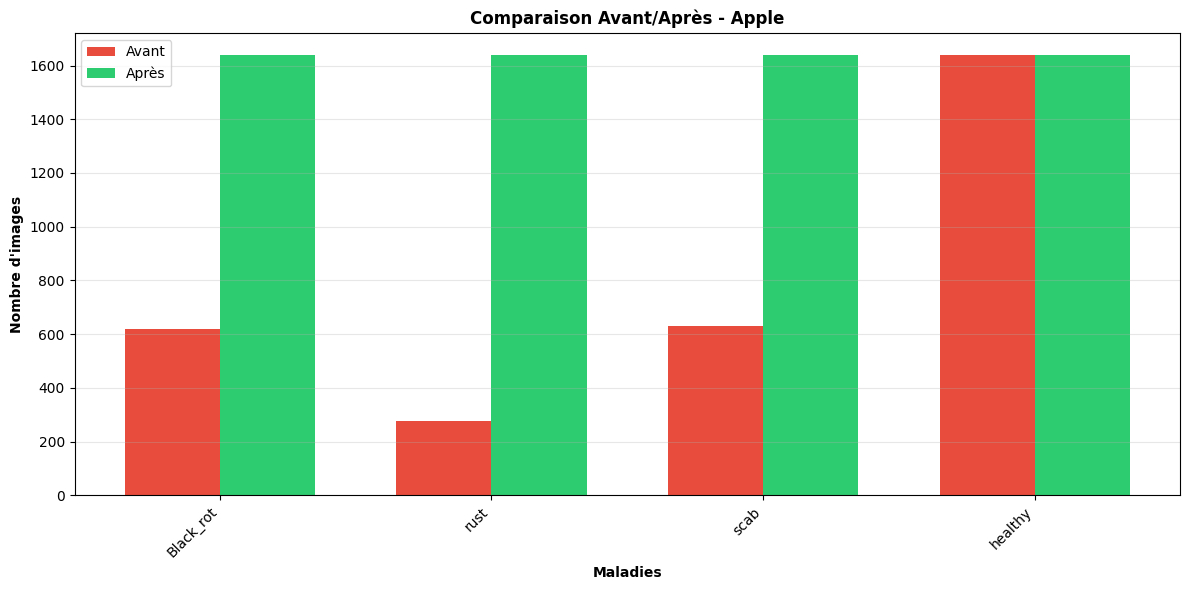

In [ ]:
def plot_before_after_comparison(stats_before, stats_after):
    """
    Compare les statistiques avant et après l'augmentation.
    """
    for plant_type in stats_before.keys():
        diseases = list(stats_before[plant_type].keys())
        before_counts = [stats_before[plant_type][d] for d in diseases]
        after_counts = [stats_after[plant_type][d] for d in diseases]

        x = np.arange(len(diseases))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(x - width/2, before_counts, width, label='Avant',
               color='#e74c3c')
        ax.bar(x + width/2, after_counts, width, label='Après',
               color='#2ecc71')

        ax.set_xlabel('Maladies', fontweight='bold')
        ax.set_ylabel('Nombre d\'images', fontweight='bold')
        ax.set_title(f'Comparaison Avant/Après - {plant_type}',
                     fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(diseases, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

stats_before = analyze_dataset(DATA_DIR)
stats_after = analyze_dataset(DATA_DIR)
plot_before_after_comparison(stats_before, stats_after)